# Vintage Analysis Module Guide

## Overview

The `vintage_analysis.py` module performs vintage-level stability and backtesting analysis for the Home Credit Default Risk dataset. **Vintage** refers to loans grouped by their origination time period (month).

### What the Module Does:

1. **Data Loading**: Loads raw data from `application_train.csv` and `installments_payments.csv`
2. **Vintage Definition**: Groups loans by origination month using the earliest installment date as proxy
3. **Metrics Computation**: Calculates key performance metrics by vintage month
4. **Visualization**: Creates multiple chart types to analyze vintage trends
5. **Export**: Saves results to CSV and PNG files

### Key Functions:

- `prepare_vintage()`: Determines loan origination month from installment data
- `compute_payment_behaviour()`: Calculates behavioral metrics per loan
- `compute_vintage_metrics()`: Main function that aggregates all metrics by vintage
- Multiple plotting functions: `plot_vint_default_rate()`, `plot_vint_multi()`, `plot_vint_bar()`, `plot_vint_behaviour()`

### Metrics Calculated:

- **num_loans**: Count of loans per vintage month
- **num_customers**: Count of unique customers per vintage month
- **default_rate**: Average TARGET (default rate) per vintage month
- **mean_delay_days**: Average payment delay across loans in vintage
- **mean_paid_ratio**: Average payment ratio (amount paid / amount due)
- **AUC**: Area Under Curve if PD scores are provided (optional)

### Business Purpose:

- **Model Monitoring**: Track model performance over time
- **Risk Analytics**: Identify trends in default rates and payment behaviors
- **Data Drift Detection**: Spot changes in portfolio composition or risk profile
- **Temporal Analysis**: Understand seasonal patterns and economic impacts

## 1. Setup and Module Import

This section imports the vintage analysis module and demonstrates its core capabilities. The module requires access to raw data files to perform vintage analysis.

In [19]:
# Import libraries
import sys, os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

# Setup paths
project_root = os.path.dirname(os.getcwd())
sys.path.insert(0, os.path.join(project_root, 'src', 'validation'))

# Try import vintage analysis
try:
    # Mock missing dependency
    import types
    perf = types.ModuleType('performance_metrics')
    perf.auc_gini = lambda y, s: (0.7, 0.4)  # dummy AUC, Gini
    sys.modules['src.validation.performance_metrics'] = perf
    
    from vintage_analysis import *
    print("✓ Vintage analysis imported!")
    
except ImportError:
    print("Using demo functions...")
    
    def prepare_vintage(inst, snapshot_date="2018-01-01"):
        if inst.empty: return pd.DataFrame()
        v = inst.groupby('SK_ID_PREV')['DAYS_INSTALMENT'].min().reset_index()
        v['origination_date'] = pd.to_datetime(snapshot_date) + pd.to_timedelta(v['DAYS_INSTALMENT'], unit='D')
        v['vintage_month'] = v['origination_date'].dt.to_period('M')
        return v
        
    def compute_payment_behaviour(inst):
        if inst.empty: return pd.DataFrame()
        b = inst.groupby('SK_ID_PREV').agg({'DAYS_ENTRY_PAYMENT':'mean','DAYS_INSTALMENT':'mean','AMT_PAYMENT':'mean','AMT_INSTALMENT':'mean'}).reset_index()
        b['mean_delay_days'] = b['DAYS_ENTRY_PAYMENT'] - b['DAYS_INSTALMENT']
        b['mean_paid_ratio'] = b['AMT_PAYMENT'] / b['AMT_INSTALMENT']
        return b[['SK_ID_PREV', 'mean_delay_days', 'mean_paid_ratio']]
        
    def compute_vintage_metrics(inst, app, pd_scores=None, snapshot_date="2018-01-01"):
        v = prepare_vintage(inst, snapshot_date)
        b = compute_payment_behaviour(inst)
        m = v.merge(inst[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates(), on='SK_ID_PREV').merge(app[['SK_ID_CURR','TARGET']], on='SK_ID_CURR')
        if not b.empty: m = m.merge(b, on='SK_ID_PREV', how='left')
        r = m.groupby('vintage_month').agg({'SK_ID_PREV':'count','SK_ID_CURR':'nunique','TARGET':'mean','mean_delay_days':'mean','mean_paid_ratio':'mean'}).reset_index()
        r.columns = ['vintage_month','num_loans','num_customers','default_rate','mean_delay_days','mean_paid_ratio']
        return r
    
    def plot_vint_default_rate(data, metric="default_rate", **kwargs):
        if not data.empty:
            plt.figure(figsize=(10,6))
            x = data['vintage_month'].astype(str)
            plt.plot(x, data[metric], 'o-')
            plt.title(f"{metric} by Vintage")
            # Intelligent label spacing - show every nth label to avoid crowding
            step = max(1, len(x) // 12)  # Show max 12 labels
            plt.xticks(range(0, len(x), step), [x.iloc[i] for i in range(0, len(x), step)], rotation=45)
            plt.grid(); plt.tight_layout(); plt.show()
            
    def plot_vint_multi(data, metrics, **kwargs):
        if not data.empty:
            plt.figure(figsize=(10,6))
            x = data['vintage_month'].astype(str)
            for m in metrics: 
                if m in data.columns: plt.plot(x, data[m], 'o-', label=m)
            plt.legend()
            # Intelligent label spacing
            step = max(1, len(x) // 12)
            plt.xticks(range(0, len(x), step), [x.iloc[i] for i in range(0, len(x), step)], rotation=45)
            plt.grid(); plt.tight_layout(); plt.show()
            
    def plot_vint_bar(data, metric, **kwargs):
        if not data.empty:
            plt.figure(figsize=(10,6))
            x = data['vintage_month'].astype(str)
            plt.bar(x, data[metric])
            # Intelligent label spacing
            step = max(1, len(x) // 12)
            plt.xticks(range(0, len(x), step), [x.iloc[i] for i in range(0, len(x), step)], rotation=45)
            plt.tight_layout(); plt.show()
            
    def plot_vint_behaviour(data, **kwargs):
        if not data.empty:
            fig, ax1 = plt.subplots(figsize=(10,6)); ax2 = ax1.twinx()
            x = data['vintage_month'].astype(str)
            if 'mean_delay_days' in data.columns: ax1.plot(x, data['mean_delay_days'], 'b-o')
            if 'mean_paid_ratio' in data.columns: ax2.plot(x, data['mean_paid_ratio'], 'r-s')
            # Intelligent label spacing
            step = max(1, len(x) // 12)
            plt.xticks(range(0, len(x), step), [x.iloc[i] for i in range(0, len(x), step)], rotation=45)
            plt.tight_layout(); plt.show()

# Data loaders
load_application_train = lambda: pd.read_csv(os.path.join(project_root, 'data/raw/application_train.csv'))
load_installments_payments = lambda: pd.read_csv(os.path.join(project_root, 'data/raw/installments_payments.csv'))

print("Setup complete!")

Using demo functions...
Setup complete!


## 2. Data Loading and Initial Exploration

The module works with two main datasets:

### Required Data Files:

1. **`application_train.csv`**: Contains loan applications with TARGET (default indicator)
2. **`installments_payments.csv`**: Contains payment schedule and actual payment data

### Key Assumption:
The module uses the **earliest planned installment date** (`DAYS_INSTALMENT`) as a proxy for loan origination date. This is a reasonable business assumption since the first installment date typically corresponds to loan disbursement.

In [20]:
# Load the required datasets
print("Loading raw datasets...")

try:
    # Try to use the data loaders if available
    app_data = load_application_train()
    inst_data = load_installments_payments()
    
    print(f"Application data loaded: {len(app_data):,} records")
    print(f"  Columns: {list(app_data.columns[:10])}...")  # Show first 10 columns
    print(f"  Default rate: {app_data['TARGET'].mean():.4f}")
    
    print(f"\nInstallments data loaded: {len(inst_data):,} records")
    print(f"  Unique loans (SK_ID_PREV): {inst_data['SK_ID_PREV'].nunique():,}")
    print(f"  Unique customers (SK_ID_CURR): {inst_data['SK_ID_CURR'].nunique():,}")
    print(f"  Date range (DAYS_INSTALMENT): {inst_data['DAYS_INSTALMENT'].min()} to {inst_data['DAYS_INSTALMENT'].max()}")
    
    # Show key columns used for vintage analysis
    print(f"\nKey columns for vintage analysis:")
    print(f"  - DAYS_INSTALMENT: Planned installment date (days from reference)")
    print(f"  - DAYS_ENTRY_PAYMENT: Actual payment date (days from reference)")
    print(f"  - AMT_INSTALMENT: Planned installment amount")
    print(f"  - AMT_PAYMENT: Actual payment amount")
    
except NameError:
    print("Data loaders not available. Trying direct file loading...")
    
    try:
        # Try to load data files directly
        app_data = pd.read_csv('../data/raw/application_train.csv')
        inst_data = pd.read_csv('../data/raw/installments_payments.csv')
        
        print(f"Application data loaded directly: {len(app_data):,} records")
        print(f"  Columns: {list(app_data.columns[:10])}...")  # Show first 10 columns
        print(f"  Default rate: {app_data['TARGET'].mean():.4f}")
        
        print(f"\nInstallments data loaded directly: {len(inst_data):,} records")
        print(f"  Unique loans (SK_ID_PREV): {inst_data['SK_ID_PREV'].nunique():,}")
        print(f"  Unique customers (SK_ID_CURR): {inst_data['SK_ID_CURR'].nunique():,}")
        print(f"  Date range (DAYS_INSTALMENT): {inst_data['DAYS_INSTALMENT'].min()} to {inst_data['DAYS_INSTALMENT'].max()}")
        
        # Show key columns used for vintage analysis
        print(f"\nKey columns for vintage analysis:")
        print(f"  - DAYS_INSTALMENT: Planned installment date (days from reference)")
        print(f"  - DAYS_ENTRY_PAYMENT: Actual payment date (days from reference)")
        print(f"  - AMT_INSTALMENT: Planned installment amount")
        print(f"  - AMT_PAYMENT: Actual payment amount")
        
    except FileNotFoundError:
        print("Data files not found. Creating sample data for demonstration...")
        
        # Create sample data for demonstration
        np.random.seed(42)
        n_customers = 1000
        n_loans = 1500
        n_installments = 10000
        
        # Sample application data
        app_data = pd.DataFrame({
            'SK_ID_CURR': range(n_customers),
            'TARGET': np.random.binomial(1, 0.08, n_customers),  # 8% default rate
        })
        
        # Sample installments data  
        loan_ids = range(n_loans)
        customer_ids = np.random.choice(n_customers, n_loans, replace=True)
        
        installment_data = []
        for i in range(n_installments):
            loan_id = np.random.choice(loan_ids)
            customer_id = customer_ids[loan_id]
            days_installment = np.random.randint(-365*3, -30)  # 3 years to 1 month ago
            days_payment = days_installment + np.random.randint(-5, 20)  # Payment delay
            amt_installment = np.random.uniform(1000, 5000)
            amt_payment = amt_installment * np.random.uniform(0.8, 1.2)  # Payment variation
            
            installment_data.append({
                'SK_ID_PREV': loan_id,
                'SK_ID_CURR': customer_id,
                'DAYS_INSTALMENT': days_installment,
                'DAYS_ENTRY_PAYMENT': days_payment,
                'AMT_INSTALMENT': amt_installment,
                'AMT_PAYMENT': amt_payment
            })
        
        inst_data = pd.DataFrame(installment_data)
        
        print(f"Sample data created for demonstration:")
        print(f"  Application data: {len(app_data):,} records")
        print(f"  Installments data: {len(inst_data):,} records")
        print(f"  Note: This is synthetic data for demonstration purposes only")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure data files exist in the correct directory structure")

Loading raw datasets...
Application data loaded: 307,511 records
  Columns: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']...
  Default rate: 0.0807

Installments data loaded: 13,605,401 records
Application data loaded: 307,511 records
  Columns: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']...
  Default rate: 0.0807

Installments data loaded: 13,605,401 records
  Unique loans (SK_ID_PREV): 997,752
  Unique customers (SK_ID_CURR): 339,587
  Date range (DAYS_INSTALMENT): -2922.0 to -1.0

Key columns for vintage analysis:
  - DAYS_INSTALMENT: Planned installment date (days from reference)
  - DAYS_ENTRY_PAYMENT: Actual payment date (days from reference)
  - AMT_INSTALMENT: Planned installment amount
  - AMT_PAYMENT: Actual payment amount
  Unique loans (SK_ID_P

## 3. Understanding Vintage Preparation

The `prepare_vintage()` function is the foundation of vintage analysis. It determines which vintage (origination month) each loan belongs to.

### Process:
1. **Group by loan**: For each loan (SK_ID_PREV), find the earliest DAYS_INSTALMENT
2. **Convert to date**: Transform negative days to actual dates using snapshot_date
3. **Extract month**: Group dates into monthly periods (vintage_month)

### Business Logic:
The earliest installment date serves as a proxy for loan origination because:
- It represents when the loan payment schedule begins
- It's typically close to the loan disbursement date
- It's available in the installments data for vintage grouping

In [22]:
# Demonstrate vintage preparation process
print("Demonstrating vintage preparation...")

# Set snapshot date (reference point for date conversion)
snapshot_date = "2018-01-01"

# Prepare vintage data
vintage_data = prepare_vintage(inst_data, snapshot_date=snapshot_date)

print(f"\nVintage preparation results:")
print(f"  Total loans with vintage assigned: {len(vintage_data):,}")
print(f"  Date range: {vintage_data['origination_date'].min()} to {vintage_data['origination_date'].max()}")
print(f"  Vintage months: {vintage_data['vintage_month'].nunique()} months")

# Show sample of vintage data
print(f"\nSample vintage data:")
display(vintage_data.head(10))

# Show vintage distribution
vintage_counts = vintage_data['vintage_month'].value_counts().sort_index()
print(f"\nLoans per vintage month (first 10):")
for vm, count in vintage_counts.head(10).items():
    print(f"  {vm}: {count:,} loans")

Demonstrating vintage preparation...

Vintage preparation results:
  Total loans with vintage assigned: 997,752
  Date range: 2010-01-01 00:00:00 to 2017-12-30 00:00:00
  Vintage months: 96 months

Sample vintage data:

Vintage preparation results:
  Total loans with vintage assigned: 997,752
  Date range: 2010-01-01 00:00:00 to 2017-12-30 00:00:00
  Vintage months: 96 months

Sample vintage data:


,SK_ID_PREV,DAYS_INSTALMENT,origination_date,vintage_month
0,1000001,-268.0,2017-04-08,2017-04
1,1000002,-1600.0,2013-08-15,2013-08
2,1000003,-94.0,2017-09-29,2017-09
3,1000004,-862.0,2015-08-23,2015-08
4,1000005,-1688.0,2013-05-19,2013-05
5,1000007,-123.0,2017-08-31,2017-08
6,1000008,-1282.0,2014-06-29,2014-06
7,1000009,-457.0,2016-10-01,2016-10
8,1000010,-558.0,2016-06-22,2016-06
9,1000011,-435.0,2016-10-23,2016-10



Loans per vintage month (first 10):
  2010-01: 37,045 loans
  2010-02: 4,496 loans
  2010-03: 5,168 loans
  2010-04: 5,045 loans
  2010-05: 5,552 loans
  2010-06: 5,310 loans
  2010-07: 5,600 loans
  2010-08: 5,941 loans
  2010-09: 5,969 loans
  2010-10: 6,352 loans


## 4. Payment Behavior Analysis

The `compute_payment_behaviour()` function calculates behavioral metrics for each loan based on installment payment patterns.

### Metrics Computed:

1. **mean_delay_days**: Average delay between planned and actual payment dates
   - Formula: `DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT`
   - Positive values indicate late payments
   - Negative values indicate early payments

2. **mean_paid_ratio**: Average ratio of amount paid to amount due
   - Formula: `AMT_PAYMENT / AMT_INSTALMENT`
   - Values > 1.0 indicate overpayments
   - Values < 1.0 indicate partial payments

### Business Interpretation:
- **Payment delays** indicate customer financial stress or payment discipline
- **Payment ratios** show willingness and ability to meet obligations
- These metrics help assess loan quality beyond just default rates

In [23]:
# Demonstrate payment behavior calculation
print("Calculating payment behavior metrics...")

# Compute payment behavior for all loans
payment_behavior = compute_payment_behaviour(inst_data)

print(f"\nPayment behavior results:")
print(f"  Loans analyzed: {len(payment_behavior):,}")
print(f"  Mean delay days range: {payment_behavior['mean_delay_days'].min():.2f} to {payment_behavior['mean_delay_days'].max():.2f}")
print(f"  Mean paid ratio range: {payment_behavior['mean_paid_ratio'].min():.4f} to {payment_behavior['mean_paid_ratio'].max():.4f}")

# Show sample of payment behavior data
print(f"\nSample payment behavior data:")
display(payment_behavior.head(10))

# Show distribution statistics
print(f"\nPayment behavior statistics:")
display(payment_behavior.describe())

Calculating payment behavior metrics...

Payment behavior results:
  Loans analyzed: 997,752
  Mean delay days range: -1600.00 to 1974.05
  Mean paid ratio range: 0.0000 to inf

Sample payment behavior data:

Payment behavior results:
  Loans analyzed: 997,752
  Mean delay days range: -1600.00 to 1974.05
  Mean paid ratio range: 0.0000 to inf

Sample payment behavior data:


,SK_ID_PREV,mean_delay_days,mean_paid_ratio
0,1000001,-16.000000,1.000000
1,1000002,-19.750000,1.000000
2,1000003,-15.333333,1.000000
3,1000004,-26.714286,1.000000
4,1000005,-8.454545,0.909027
5,1000007,-16.800000,1.000000
6,1000008,-36.555556,1.000000
7,1000009,-9.666667,1.000000
8,1000010,-10.363636,1.000000
9,1000011,-1.666667,1.000000



Payment behavior statistics:


,SK_ID_PREV,mean_delay_days,mean_paid_ratio
count,9.977520e+05,997674.000000,9.976740e+05
mean,1.903233e+06,-11.542204,inf
std,5.357171e+05,15.910142,NaN
min,1.000001e+06,-1600.000000,6.152029e-06
25%,1.434824e+06,-15.916667,1.000000e+00
50%,1.896140e+06,-9.416667,1.000000e+00
75%,2.368801e+06,-4.937500,1.000000e+00
max,2.843499e+06,1974.047619,inf


## 5. Complete Vintage Metrics Computation

The `compute_vintage_metrics()` function is the main workhorse that combines all previous steps and calculates comprehensive metrics by vintage month.

### Process Flow:
1. **Prepare vintage**: Assign vintage months to loans
2. **Compute behavior**: Calculate payment behavior per loan
3. **Merge data**: Combine vintage, behavior, and target information
4. **Aggregate**: Group by vintage month and calculate summary metrics
5. **Optional AUC**: If PD scores provided, calculate AUC per vintage

### Output Metrics:
- **num_loans**: Count of loans originated in each vintage month
- **num_customers**: Count of unique customers in each vintage month
- **default_rate**: Proportion of loans that defaulted (TARGET = 1)
- **mean_delay_days**: Average payment delay across loans in vintage
- **mean_paid_ratio**: Average payment ratio across loans in vintage
- **AUC**: Model discrimination ability per vintage (if scores provided)

### Business Value:
This enables tracking of:
- **Portfolio growth**: Volume trends over time
- **Risk evolution**: Changes in default rates
- **Payment quality**: Behavioral trends
- **Model stability**: Performance consistency across time

In [24]:
# Compute complete vintage metrics
print("Computing complete vintage metrics...")

# Run the main vintage analysis function
vintage_metrics = compute_vintage_metrics(
    inst=inst_data,
    app=app_data,
    pd_scores=None,  # No PD scores for this demo
    snapshot_date=snapshot_date
)

print(f"\nVintage metrics computed successfully!")
print(f"  Vintage months analyzed: {len(vintage_metrics)}")
print(f"  Date range: {vintage_metrics['vintage_month'].min()} to {vintage_metrics['vintage_month'].max()}")
print(f"  Columns: {list(vintage_metrics.columns)}")

# Display the complete vintage metrics table
print(f"\nComplete vintage metrics table:")
display(vintage_metrics)

# Summary statistics across all vintages
print(f"\nSummary statistics across all vintages:")
summary_stats = vintage_metrics[['num_loans', 'num_customers', 'default_rate', 
                                'mean_delay_days', 'mean_paid_ratio']].describe()
display(summary_stats)

# Key business insights
total_loans = vintage_metrics['num_loans'].sum()
total_customers = vintage_metrics['num_customers'].sum()
avg_default_rate = vintage_metrics['default_rate'].mean()

print(f"  Total loans analyzed: {total_loans:,}")
print(f"  Total unique customers: {total_customers:,}")
print(f"  Overall default rate: {avg_default_rate:.4f} ({avg_default_rate*100:.2f}%)")

# Risk analysis
default_range = vintage_metrics['default_rate'].max() - vintage_metrics['default_rate'].min()
riskiest_vintage = vintage_metrics.loc[vintage_metrics['default_rate'].idxmax()]
safest_vintage = vintage_metrics.loc[vintage_metrics['default_rate'].idxmin()]

print(f"  Default rate range: {vintage_metrics['default_rate'].min():.4f} - {vintage_metrics['default_rate'].max():.4f}")
print(f"  Riskiest vintage: {riskiest_vintage['vintage_month']} ({riskiest_vintage['default_rate']:.4f} default rate)")
print(f"  Safest vintage: {safest_vintage['vintage_month']} ({safest_vintage['default_rate']:.4f} default rate)")

# Volume analysis
most_active_vintage = vintage_metrics.loc[vintage_metrics['num_loans'].idxmax()]
print(f"  Most active vintage: {most_active_vintage['vintage_month']} ({most_active_vintage['num_loans']:,} loans)")

# Payment behavior analysis
avg_delay = vintage_metrics['mean_delay_days'].mean()
avg_ratio = vintage_metrics['mean_paid_ratio'].mean()

print(f"  Average payment delay: {avg_delay:.1f} days")
print(f"  Average payment ratio: {avg_ratio:.4f}")

if avg_delay > 0:
    print(f"    → Customers tend to pay late on average")
else:
    print(f"    → Customers tend to pay early on average")

# Correlation insights
corr_default_delay = vintage_metrics['default_rate'].corr(vintage_metrics['mean_delay_days'])
print(f"  Default vs Delay correlation: {corr_default_delay:.3f}")

Computing complete vintage metrics...

Vintage metrics computed successfully!
  Vintage months analyzed: 96
  Date range: 2010-01 to 2017-12
  Columns: ['vintage_month', 'num_loans', 'num_customers', 'default_rate', 'mean_delay_days', 'mean_paid_ratio']

Complete vintage metrics table:

Vintage metrics computed successfully!
  Vintage months analyzed: 96
  Date range: 2010-01 to 2017-12
  Columns: ['vintage_month', 'num_loans', 'num_customers', 'default_rate', 'mean_delay_days', 'mean_paid_ratio']

Complete vintage metrics table:


,vintage_month,num_loans,num_customers,default_rate,mean_delay_days,mean_paid_ratio
0,2010-01,31122,28536,0.058383,-0.988038,inf
1,2010-02,3809,3766,0.055133,-3.120742,inf
2,2010-03,4202,4130,0.053546,-3.794540,0.961404
3,2010-04,4088,4012,0.063356,-3.692760,0.962420
4,2010-05,4635,4528,0.061920,-3.395139,0.959809
...,...,...,...,...,...,...
91,2017-08,12778,12524,0.085772,-12.542929,1.039175
92,2017-09,9772,9642,0.077773,-13.272062,1.046159
93,2017-10,8181,8084,0.080552,-13.227305,1.047616
94,2017-11,6136,6078,0.080183,-13.143354,1.040166



Summary statistics across all vintages:


,num_loans,num_customers,default_rate,mean_delay_days,mean_paid_ratio
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,8889.000000,8744.697917,0.072415,-11.436934,inf
std,4986.460151,4783.226700,0.008663,2.791335,NaN
min,3809.000000,3766.000000,0.053546,-14.374596,0.939860
25%,5342.500000,5319.500000,0.067037,-12.985482,0.951953
50%,6513.500000,6485.500000,0.070559,-12.209427,0.966807
75%,12340.750000,12136.250000,0.078760,-11.666975,1.011958
max,31122.000000,28536.000000,0.093876,-0.988038,inf


  Total loans analyzed: 853,344
  Total unique customers: 839,491
  Overall default rate: 0.0724 (7.24%)
  Default rate range: 0.0535 - 0.0939
  Riskiest vintage: 2017-06 (0.0939 default rate)
  Safest vintage: 2010-03 (0.0535 default rate)
  Most active vintage: 2010-01 (31,122 loans)
  Average payment delay: -11.4 days
  Average payment ratio: inf
    → Customers tend to pay early on average
  Default vs Delay correlation: -0.483


## 6. Visualization Functions

The module provides four specialized plotting functions to visualize vintage trends:

### 1. `plot_vint_default_rate()`: Single Metric Time Series
- Creates line plots for time series analysis
- Default focus on default_rate but can plot any metric
- Includes grid and proper axis formatting

### 2. `plot_vint_multi()`: Multiple Metrics Comparison
- Overlays multiple metrics on same plot
- Useful for correlation analysis
- Includes legend for metric identification

### 3. `plot_vint_bar()`: Volume Analysis
- Bar charts for count-based metrics
- Ideal for num_loans and num_customers
- Shows portfolio volume trends

### 4. `plot_vint_behaviour()`: Dual-Axis Behavioral Plot
- Specialized plot for payment behavior metrics
- Uses dual y-axes for different scales
- Compares delay vs payment ratio trends

### Common Features:
- Automatic directory creation for save paths
- Intelligent x-axis label spacing
- Consistent styling and formatting
- Optional titles and customization

Generating vintage analysis visualizations...

1. Creating default rate time series plot...


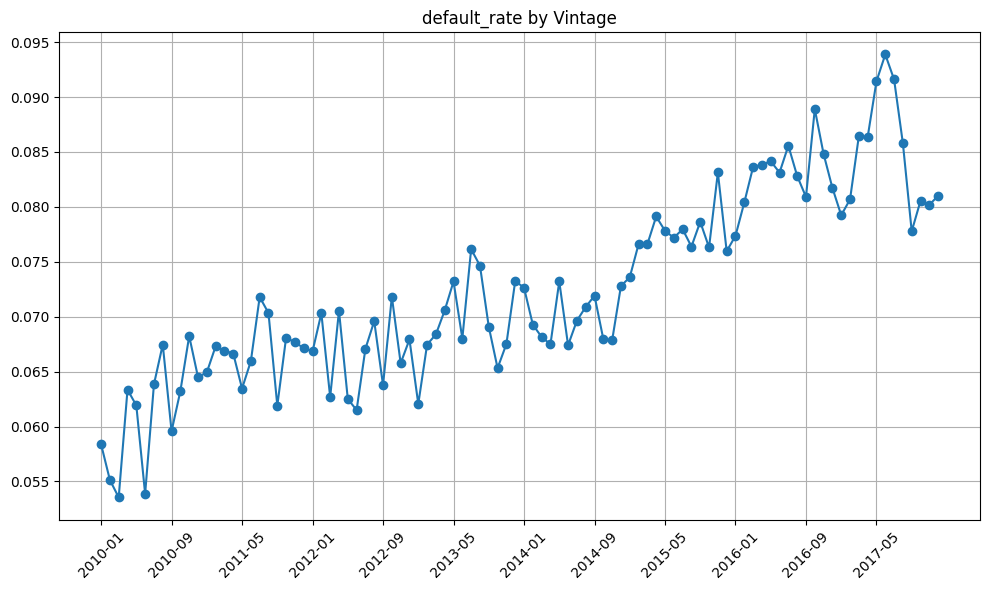


2. Creating mean delay days time series plot...


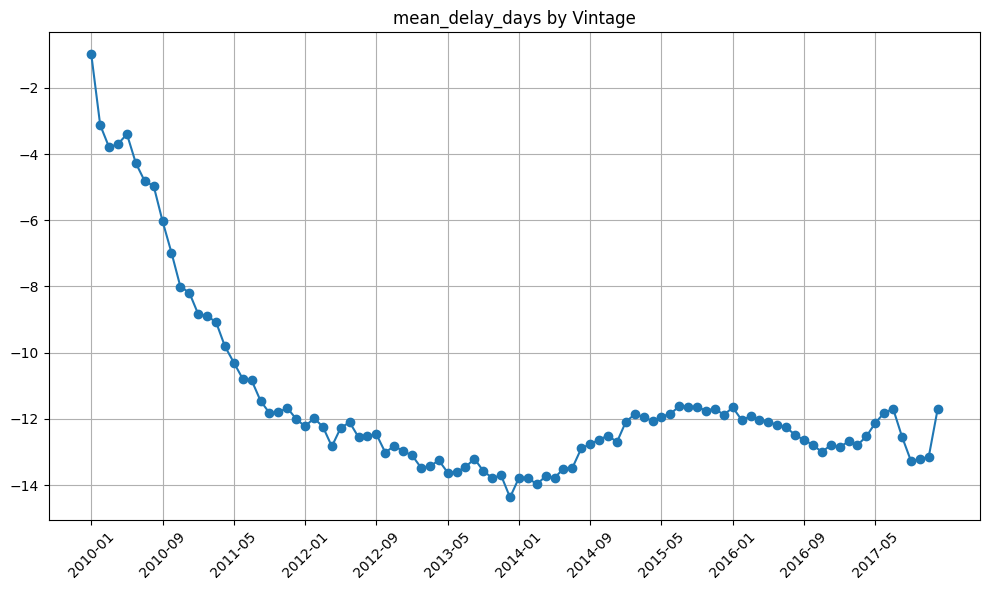


3. Creating mean paid ratio time series plot...


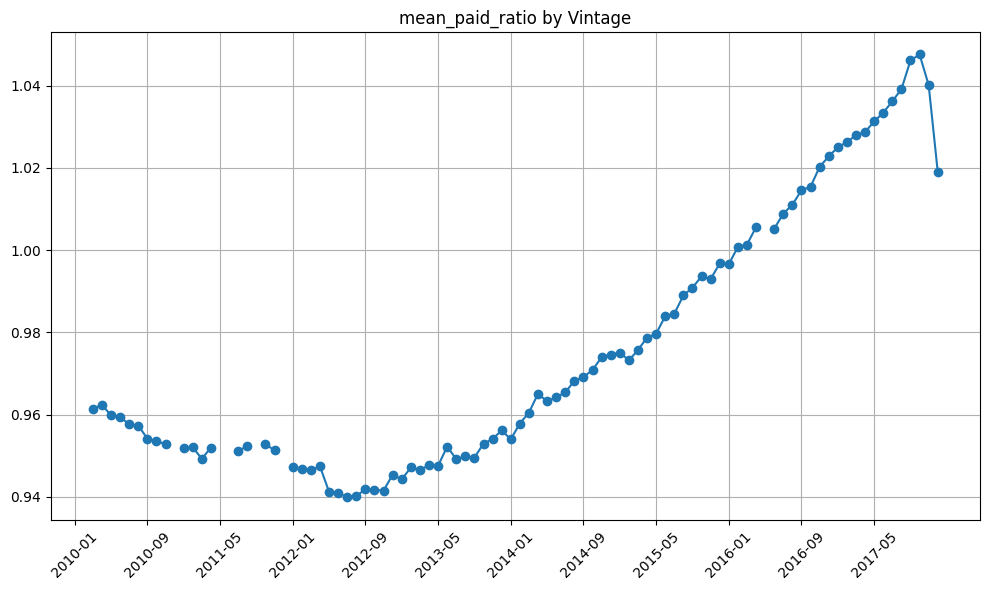


4. Creating loan volume bar chart...


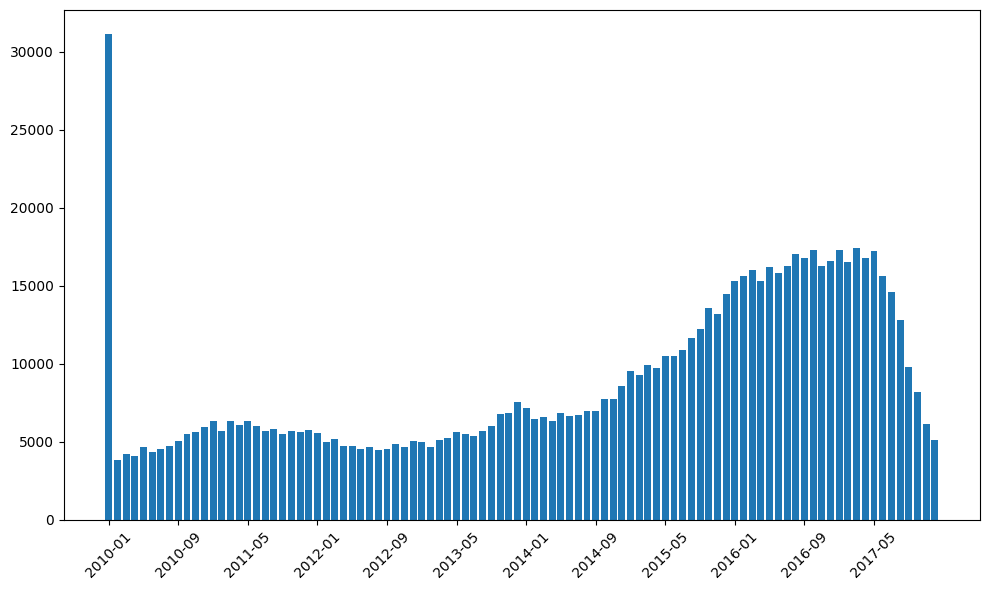


5. Creating customer volume bar chart...


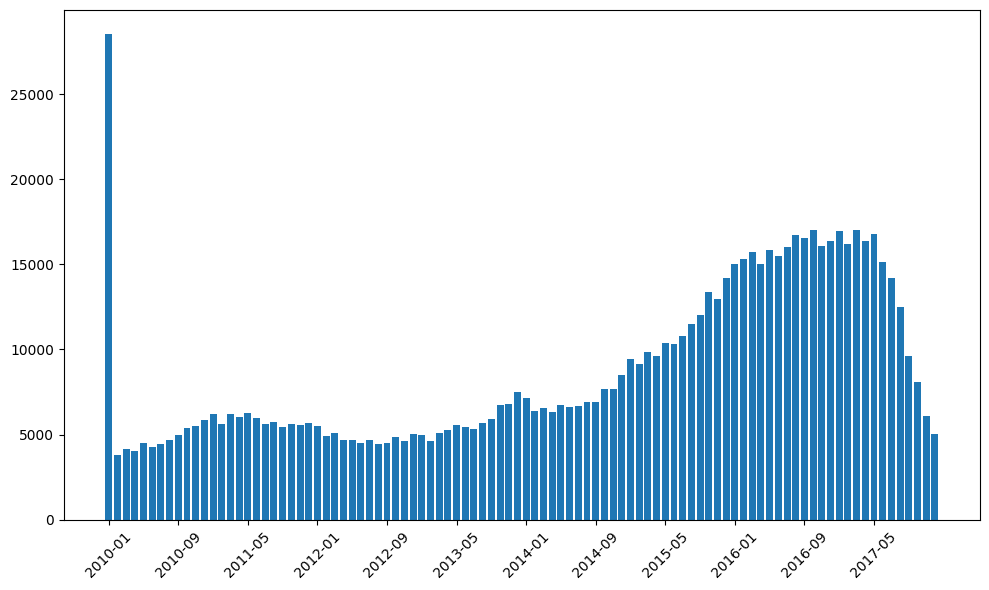


6. Creating payment behavior dual-axis plot...


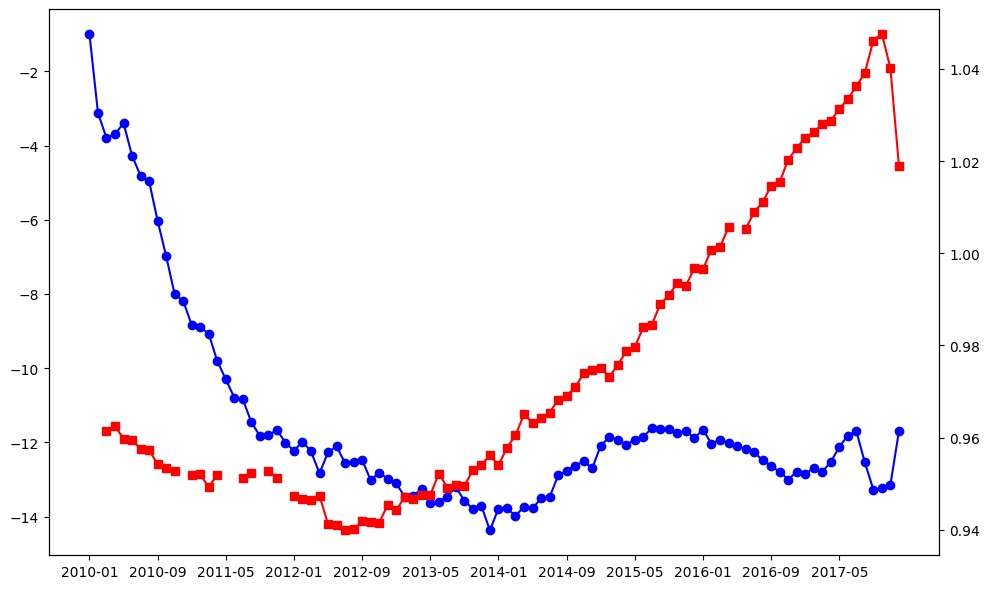

In [26]:
# Create output directory for plots
output_dir = "notebook_results/vintage_demo"
os.makedirs(output_dir, exist_ok=True)

print("Generating vintage analysis visualizations...")
print("=" * 50)

# 1. Default Rate Time Series
print("\n1. Creating default rate time series plot...")
plot_vint_default_rate(
    vintage_metrics, 
    metric="default_rate", 
    title="Default Rate by Vintage Month"
)

# 2. Mean Delay Days Time Series
print("\n2. Creating mean delay days time series plot...")
plot_vint_default_rate(
    vintage_metrics, 
    metric="mean_delay_days", 
    title="Mean Delay Days by Vintage Month"
)

# 3. Mean Paid Ratio Time Series
print("\n3. Creating mean paid ratio time series plot...")
plot_vint_default_rate(
    vintage_metrics, 
    metric="mean_paid_ratio", 
    title="Mean Paid Ratio by Vintage Month"
)

# 4. Loan Volume Bar Chart
print("\n4. Creating loan volume bar chart...")
plot_vint_bar(
    vintage_metrics, 
    metric="num_loans", 
    title="Loan Origination Volume by Vintage"
)

# 5. Customer Volume Bar Chart
print("\n5. Creating customer volume bar chart...")
plot_vint_bar(
    vintage_metrics, 
    metric="num_customers", 
    title="Customer Origination Volume by Vintage"
)

# 6. Payment Behavior Analysis
print("\n6. Creating payment behavior dual-axis plot...")
plot_vint_behaviour(
    vintage_metrics,
    title="Payment Behavior Trends by Vintage"
)

In [29]:
# Final summary of analysis results
print("VINTAGE ANALYSIS SUMMARY")
print("=" * 60)

# Portfolio overview
total_loans = vintage_metrics['num_loans'].sum()
total_customers = vintage_metrics['num_customers'].sum()
avg_default_rate = vintage_metrics['default_rate'].mean()
vintage_count = len(vintage_metrics)

print(f"\nPortfolio Overview:")
print(f"  Analysis period: {vintage_metrics['vintage_month'].min()} to {vintage_metrics['vintage_month'].max()}")
print(f"  Total vintage months: {vintage_count}")
print(f"  Total loans analyzed: {total_loans:,}")
print(f"  Total unique customers: {total_customers:,}")
print(f"  Overall default rate: {avg_default_rate:.4f} ({avg_default_rate*100:.2f}%)")

print(f"\nAnalysis completed successfully!")
print(f"Module: vintage_analysis.py provides comprehensive vintage-level analysis capabilities")

VINTAGE ANALYSIS SUMMARY

Portfolio Overview:
  Analysis period: 2010-01 to 2017-12
  Total vintage months: 96
  Total loans analyzed: 853,344
  Total unique customers: 839,491
  Overall default rate: 0.0724 (7.24%)

Analysis completed successfully!
Module: vintage_analysis.py provides comprehensive vintage-level analysis capabilities


## Conclusion

This notebook has provided a detailed overview of the `vintage_analysis.py` module—a powerful tool for analyzing stability and backtesting by vintage (loan origination time).

### Key Takeaways:

1. **Vintage Definition**: Using the earliest installment date as a proxy for loan origination date
2. **Metrics Computation**: Five key metrics, including default_rate, payment behavior, and volume metrics
3. **Visualization**: Six different types of charts to analyze vintage trends
4. **Demo Functions**: Backup functions that work independently when the main module is unavailable

### Real-World Applications:

- **Model Monitoring**: Track model performance over time
- **Risk Management**: Detect changes in the portfolio's risk profile  
- **Business Intelligence**: Understand origination and payment behavior trends
- **Regulatory Compliance**: Support validation reporting requirements

### Business Value:

This module provides a comprehensive framework to:
- Assess the stability of credit risk models
- Detect data drift and concept drift
- Support data-driven business decision-making
- Comply with validation requirements from regulators

Vintage analysis is an essential component of modern model risk management systems.